# Surface Reconstruction from Compressive Holography
### Chengyu Wang

This is a description of how I train the network to recover a surface from compressive hologram. This notebook does not include every piece of codes I used, because I generated the measurement (input data) using MATLAB.

## Generate a Field
The grountruth field is a 3D data cube of dimension (Nx = 512, Nx = 512, Nz = num_of_slice). At most ONE none-zero value for each (x,y). Due to the lack of a proper way to assign intensity to the data cube, every the non-zero point is assigned value 1, and the reconstruction problem becomes a depth estmation problem. 

There are two ways to generate a data cube: a random surface or a surface from .stl 3D models.

Random surface (MATLAB CODE)

N = [512,512];
F = 2;
[X,Y] = ndgrid(1:N(1),1:N(2));
i = min(X-1,N(1)-X+1);
j = min(Y-1,N(2)-Y+1);
H = exp(-.5*(i.^2+j.^2)/F^2);
Z = real(ifft2(H.*fft2(randn(N))));

## Generate a surface from the STL model

In [4]:
import trimesh
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import savemat
import scipy.io as sio
import os

In [2]:
## Load a 3d-model
mesh = trimesh.load_mesh('93842.stl')

## Determine the accuracy. Smaller pitch means larger datacube and longer processing time
pitch = 1

## Get the crosssection of th
volume = mesh.voxelized(pitch=pitch)
mat = volume.matrix 
mat = np.flip(np.moveaxis(mat,[0,2],[2,0]),0)

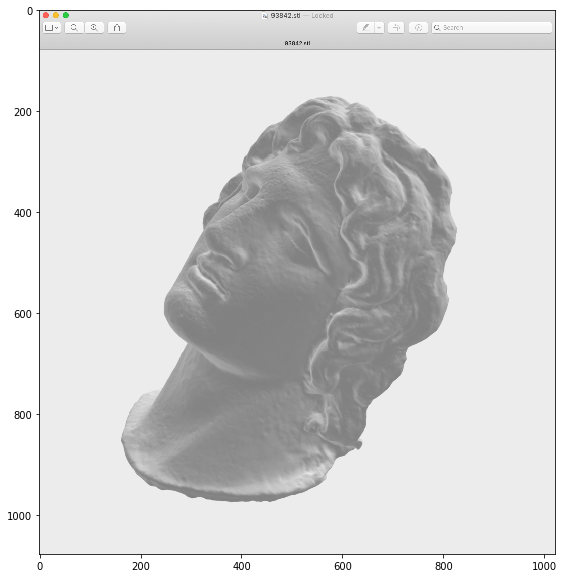

In [18]:
img = plt.imread('stl_model.png')
plt.figure(figsize=(10,10))
plt.imshow(img)

In [11]:
## The order: (X,Z,Y), so there are 214 slices
mat.shape

(366, 214, 266)

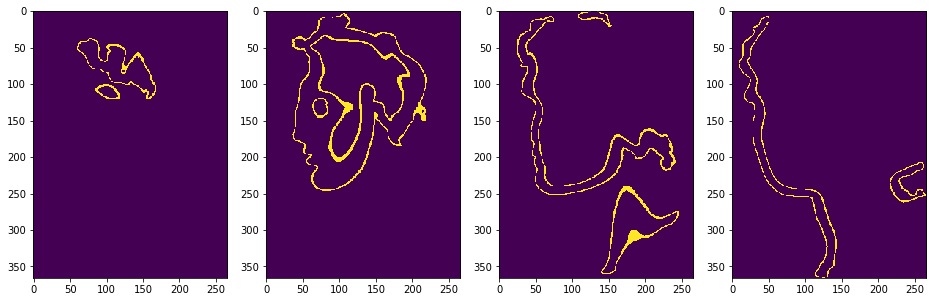

In [8]:
plt.figure(figsize = (16,8))
plt.subplot(1,4,1)
plt.imshow(mat[:,10,:])
plt.subplot(1,4,2)
plt.imshow(mat[:,30,:])
plt.subplot(1,4,3)
plt.imshow(mat[:,50,:])
plt.subplot(1,4,4)
plt.imshow(mat[:,80,:])

In [9]:
## To obtain a surface, we keep only the first non-zero value for each (x,y)
CUBE = np.ones([mat.shape[0],mat.shape[2]]) * (-1)
for i in range(mat.shape[0]):
    for j in range(mat.shape[2]):
        if np.where(mat[i,:,j] == True)[0].size > 0:
            CUBE[i,j] = np.min(np.where(mat[i,:,j] == True))

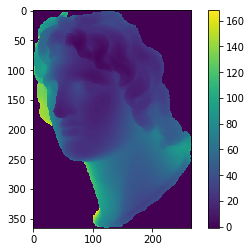

In [10]:
## 2D representation of the 3D surface. Here in this example, there are 168 slices/depth.
plt.imshow(CUBE)
plt.colorbar()

In [12]:
np.max(CUBE)

168.0

## Generate a Measurment
Given the depth of the stl surfaces, I randomly put one or two of them into a (512,512,150) cube. Then I use the code from http://disp.duke.edu/research/compressive-holography to generate measurements with the following parameters:

size of detector pixels (um): detector_size=5.2;

wavelength (um): lambda=0.633;

distance between each axial plane (um): deltaZ=8000;

distance from detector to first reconstructed plane (um): offsetZ=0;

number of axial planes: nz = 150;

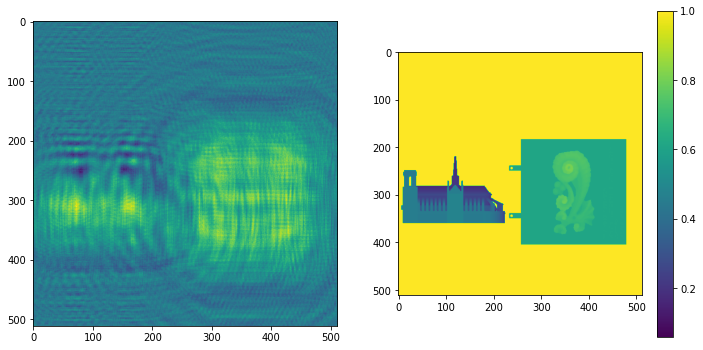

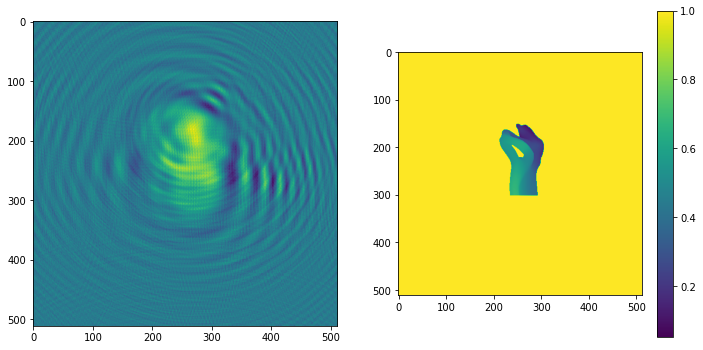

In [27]:
## Input Output pair
ID = 170
m = sio.loadmat('../train_data_stl/measurement/measurement_{}.mat'.format(ID))['m']
gt = sio.loadmat('../train_data_stl/label/gt_{}.mat'.format(ID))['label']
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(m[100:612,100:612])
plt.subplot(1,2,2)
plt.imshow(gt/150.0)
plt.colorbar()

ID = 56 
m = sio.loadmat('../train_data_stl/measurement/measurement_{}.mat'.format(ID))['m']
gt = sio.loadmat('../train_data_stl/label/gt_{}.mat'.format(ID))['label']
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.imshow(m[100:612,100:612])
plt.subplot(1,2,2)
plt.imshow(gt/150.0)
plt.colorbar()

## Network Structure

In [1]:
from tensorflow import keras
import tensorflow as tf

In [2]:
## Network structure
def down_layer(n_filter,s_filter,strides,x):
    x = keras.layers.Conv2D(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(64,3,strides=1,padding='same',activation='sigmoid')(x)
    return x

def up_layer(n_filter,s_filter,strides,x):
    x = keras.layers.Conv2DTranspose(n_filter,s_filter,strides=strides,activation='sigmoid')(x)
#     x = keras.layers.Conv2D(64,3,strides=1,padding='same',activation='sigmoid')(x)
    return x

inputs = keras.Input(shape = (512,512,1))
x1 = down_layer(64,11,3,inputs)
x2 = down_layer(64,9,3,x1)
x3 = down_layer(64,3,3,x2)
x4 = down_layer(64,3,3,x3)
x5 = keras.layers.Flatten()(x4)
x5 = keras.layers.Dense(2304,activation='sigmoid')(x5)
x4_ = keras.layers.Reshape((6,6,64))(x5)
x4_ = keras.layers.Conv2D(64,3,strides=1,padding='same',activation='sigmoid')(x4_)
x3_ = up_layer(64,3,3,x4_)
x3_ = keras.layers.concatenate([x3,x3_])
x2_ = up_layer(64,3,3,x3_)
x2_ = keras.layers.concatenate([x2,x2_])
x1_ = up_layer(64,9,3,x2_)
x1_ = keras.layers.concatenate([x1,x1_])
x0_ = keras.layers.Conv2DTranspose(64,11,strides=3,activation='sigmoid')(x1_)
x = keras.layers.Conv2D(64,3,padding='same',activation='sigmoid')(x0_)
x = keras.layers.Conv2D(1,1,padding='same')(x)
model = keras.Model(inputs = inputs, outputs = x)

In [3]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 168, 168, 64) 7808        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 54, 54, 64)   331840      conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 18, 18, 64)   36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

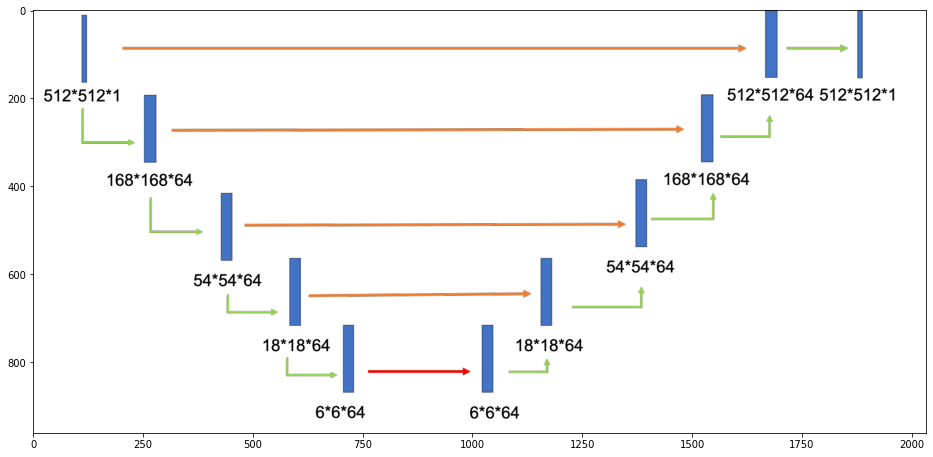

In [7]:
plt.figure(figsize=(16,10))
img = plt.imread('net.png')
plt.imshow(img)

### The network adpots the U-NET structure: The green arrow represents a CONV layer, the red arrow represent a FC layer, and the orange arrow represent a concatenate layer.